In [1]:
#ライブラリをインポート
#標準ライブラリ
import random
import pathlib

#サードパーティー製
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import timm
import torchinfo
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision

from PIL import Image
from torchvision import models, transforms
from tqdm import tqdm
from sklearn.metrics import(
    accuracy_score,
    ConfusionMatrixDisplay, confusion_matrix

)

#自作モジュール
from utils.Module import *

#乱数シードの設定
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [2]:
print(torch.__version__)

1.13.1


In [3]:
size = 32

# 概要

SwinTransformerを使用して、果物の分類モデルを作成する．<br>
基本的にはhttps://github.com/YutaroOgawa/pytorch_advanced/blob/master/1_image_classification/1-3_transfer_learning.ipynb
からコピペしている．

## 画像群を取得

In [4]:
#訓練画像のパス
list_train_path = list(pathlib.Path("Train").iterdir())
list_train_path = [str(path) for path in list_train_path]#str化

#推論画像のパス
list_val_path = list(pathlib.Path("Val").iterdir())
list_val_path = [str(path) for path in list_val_path]#str化

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

## 適用する水増し処理

In [6]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる


class ImageTransform():
    """
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。

    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, resize):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.Resize((size, size)), 
                transforms.ToTensor(),  # テンソルに変換
            ]),
            'val': transforms.Compose([
                transforms.Resize((size, size)),  # リサイズ
                transforms.ToTensor(),  # テンソルに変換
            ])
        }

    def __call__(self, img, phase='train'):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img)

## データセットを作成

In [7]:
class Dataset(data.Dataset):
    """
    アリとハチの画像のDatasetクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    file_list : リスト
        画像のパスを格納したリスト
    transform : object
        前処理クラスのインスタンス
    phase : 'train' or 'val'
        訓練か検証かを設定
    """

    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list  # ファイルパスのリスト
        self.transform = transform  # 前処理クラスのインスタンス
        self.phase = phase  # train or valの指定

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとラベルを取得
        '''

        # index番目の画像をロード
        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅][色RGB]

        # 画像の前処理を実施
        img_transformed = self.transform(
            img, self.phase)  # torch.Size([3, 224, 224])
        
        # 画像のラベルをファイル名から抜き出す
        if(self.phase == "train"):
          label = list(pd.DataFrame(list_train_path).iloc[:, 0].str.split("\\", expand = True).iloc[:, -1].str.split("_", expand = True).iloc[:, 0])[index]
        else:
          label = list(pd.DataFrame(list_val_path).iloc[:, 0].str.split("\\", expand = True).iloc[:, -1].str.split("_", expand = True).iloc[:, 0])[index]


        # ラベルを数値に変更する
        if label == "apple":
            label = 0
        elif label == "tomato":
            label = 1
        elif label == "cherry":
            label = 2

        return img_transformed, label

In [8]:
# 実行
train_dataset = Dataset(
    file_list=list_train_path, transform=ImageTransform(size), phase='train')

val_dataset = Dataset(
    file_list=list_val_path, transform=ImageTransform(size), phase='val')

## DataLoaderの作成

In [9]:
# ミニバッチのサイズを指定
batch_size = 64

# DataLoaderを作成
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

## モデルをロード

In [10]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.cbr_1 = conv2DBatchNormRelu(
            3, 16, kernel_size=3, stride=1, padding=1, dilation=1, bias=True)
        self.ppm = PyramidPooling(
            16, [16, 6, 3, 2, 1], 16, 16
        )
        self.maxpool2d = nn.MaxPool2d(3, stride=2, padding=1)
        self.flatten = nn.Flatten()
        self.fc_1 = nn.Linear(7936, 3968)
        self.fc_2 = nn.Linear(3968, 3)
        
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        #畳み込み層
        x = self.maxpool2d(self.cbr_1(x))
        x = self.ppm(x)
        
        #全結合層
        x = self.sigmoid(self.fc_1(self.flatten(x)))
        x = self.fc_2(x)
        
        return x

In [11]:
model = Model()

In [12]:
torchinfo.summary(
    model,
    input_size=(batch_size, 3, 32, 32),
    col_names=["output_size", "num_params"],
)

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [64, 3]                   --
├─conv2DBatchNormRelu: 1-1               [64, 16, 32, 32]          --
│    └─Conv2d: 2-1                       [64, 16, 32, 32]          448
│    └─BatchNorm2d: 2-2                  [64, 16, 32, 32]          32
│    └─ReLU: 2-3                         [64, 16, 32, 32]          --
│    └─Dropout2d: 2-4                    [64, 16, 32, 32]          --
├─MaxPool2d: 1-2                         [64, 16, 16, 16]          --
├─PyramidPooling: 1-3                    [64, 31, 16, 16]          --
│    └─AdaptiveAvgPool2d: 2-5            [64, 16, 16, 16]          --
│    └─conv2DBatchNormRelu: 2-6          [64, 3, 16, 16]           --
│    │    └─Conv2d: 3-1                  [64, 3, 16, 16]           48
│    │    └─BatchNorm2d: 3-2             [64, 3, 16, 16]           6
│    │    └─ReLU: 3-3                    [64, 3, 16, 16]           --
│    │    └─Dro

## 損失関数の定義

In [13]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

## 最適化手法を設定

In [14]:
# 最適化手法の設定
optimizer = optim.Adadelta(model.parameters())

## 学習と検証を実施

In [15]:
#decice = "cuda:0"
decice = "cpu"

In [16]:
# モデルを学習させる関数を作成


def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    #モデルをGPUへ
    net.to(decice)
    #lossを保存
    list_train_loss = []
    list_val_loss = []
    #正解率を保存
    list_train_acc = []
    list_val_acc = []

    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            if (epoch == 0) and (phase == 'train'):
                continue

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                #GPUへ
                inputs = inputs.to(decice)
                labels = labels.to(decice)
                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)  # ラベルを予測
                    
  
                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # イタレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)  
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)
            
            #訓練の場合
            if(phase == "train"):
                list_train_loss.append(epoch_loss)
                list_train_acc.append(epoch_acc)
            #推論の場合
            else:
                list_val_loss.append(epoch_loss)
                list_val_acc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
    torch.save(net.state_dict(), 'model_weight.pth')
            
    return list_train_loss, list_train_acc, list_val_loss, list_val_acc

In [17]:
# 学習・検証を実行する
num_epochs=50
list_train_loss, list_train_acc, list_val_loss, list_val_acc = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:13<00:00,  2.45it/s]


val Loss: 1.1066 Acc: 0.3333
Epoch 2/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.61it/s]


train Loss: 2.6394 Acc: 0.4284


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:18<00:00,  1.82it/s]


val Loss: 2.2683 Acc: 0.3448
Epoch 3/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.03s/it]


train Loss: 0.9378 Acc: 0.5415


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.84it/s]


val Loss: 1.0328 Acc: 0.4529
Epoch 4/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.12it/s]


train Loss: 0.9099 Acc: 0.5836


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:18<00:00,  1.81it/s]


val Loss: 0.9092 Acc: 0.5362
Epoch 5/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.14it/s]


train Loss: 0.8623 Acc: 0.6246


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.85it/s]


val Loss: 0.9570 Acc: 0.6081
Epoch 6/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.15it/s]


train Loss: 0.7956 Acc: 0.6326


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:18<00:00,  1.82it/s]


val Loss: 1.0497 Acc: 0.5043
Epoch 7/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.12it/s]


train Loss: 0.8047 Acc: 0.6416


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:19<00:00,  1.70it/s]


val Loss: 0.9303 Acc: 0.5590
Epoch 8/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]


train Loss: 0.7673 Acc: 0.6617


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.53it/s]


val Loss: 0.8081 Acc: 0.6238
Epoch 9/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.12it/s]


train Loss: 0.6916 Acc: 0.7037


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:15<00:00,  2.08it/s]


val Loss: 1.0762 Acc: 0.5952
Epoch 10/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.35it/s]


train Loss: 0.6972 Acc: 0.7027


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.99it/s]


val Loss: 0.9378 Acc: 0.5562
Epoch 11/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.33it/s]


train Loss: 0.6964 Acc: 0.6907


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:14<00:00,  2.35it/s]


val Loss: 0.6857 Acc: 0.7224
Epoch 12/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.44it/s]


train Loss: 0.6673 Acc: 0.7157


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:14<00:00,  2.32it/s]


val Loss: 0.8412 Acc: 0.6438
Epoch 13/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.39it/s]


train Loss: 0.6547 Acc: 0.7137


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:14<00:00,  2.35it/s]


val Loss: 0.7846 Acc: 0.6571
Epoch 14/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.41it/s]


train Loss: 0.6090 Acc: 0.7427


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:14<00:00,  2.34it/s]


val Loss: 0.8954 Acc: 0.6195
Epoch 15/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.40it/s]


train Loss: 0.6723 Acc: 0.7107


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:15<00:00,  2.18it/s]


val Loss: 1.0252 Acc: 0.5657
Epoch 16/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.43it/s]


train Loss: 0.6205 Acc: 0.7287


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:14<00:00,  2.28it/s]


val Loss: 0.7729 Acc: 0.6643
Epoch 17/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.43it/s]


train Loss: 0.5971 Acc: 0.7447


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:15<00:00,  2.13it/s]


val Loss: 0.8473 Acc: 0.6143
Epoch 18/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.36it/s]


train Loss: 0.5497 Acc: 0.7568


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.99it/s]


val Loss: 0.7975 Acc: 0.6533
Epoch 19/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.41it/s]


train Loss: 0.5521 Acc: 0.7688


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:13<00:00,  2.36it/s]


val Loss: 0.7620 Acc: 0.6938
Epoch 20/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.37it/s]


train Loss: 0.4703 Acc: 0.8118


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:15<00:00,  2.15it/s]


val Loss: 0.8589 Acc: 0.6567
Epoch 21/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.32it/s]


train Loss: 0.4925 Acc: 0.7938


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:15<00:00,  2.14it/s]


val Loss: 0.8575 Acc: 0.6471
Epoch 22/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.38it/s]


train Loss: 0.4479 Acc: 0.8008


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.96it/s]


val Loss: 0.6943 Acc: 0.7310
Epoch 23/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.43it/s]


train Loss: 0.4455 Acc: 0.8188


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.87it/s]


val Loss: 0.7250 Acc: 0.7057
Epoch 24/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.18it/s]


train Loss: 0.4728 Acc: 0.7998


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:15<00:00,  2.11it/s]


val Loss: 1.1200 Acc: 0.5700
Epoch 25/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.18it/s]


train Loss: 0.4276 Acc: 0.8138


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  2.03it/s]


val Loss: 0.8725 Acc: 0.6929
Epoch 26/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.32it/s]


train Loss: 0.3535 Acc: 0.8468


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:13<00:00,  2.36it/s]


val Loss: 0.8480 Acc: 0.7048
Epoch 27/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.31it/s]


train Loss: 0.3838 Acc: 0.8408


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  2.02it/s]


val Loss: 1.0238 Acc: 0.6005
Epoch 28/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.29it/s]


train Loss: 0.3947 Acc: 0.8438


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.86it/s]


val Loss: 0.8370 Acc: 0.7152
Epoch 29/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.26it/s]


train Loss: 0.3764 Acc: 0.8609


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  2.00it/s]


val Loss: 0.8572 Acc: 0.6948
Epoch 30/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.43it/s]


train Loss: 0.2652 Acc: 0.9079


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:15<00:00,  2.19it/s]


val Loss: 0.8162 Acc: 0.7138
Epoch 31/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.17it/s]


train Loss: 0.2475 Acc: 0.9129


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:14<00:00,  2.29it/s]


val Loss: 1.4357 Acc: 0.6076
Epoch 32/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.28it/s]


train Loss: 0.2185 Acc: 0.9179


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.99it/s]


val Loss: 1.1230 Acc: 0.6471
Epoch 33/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.24it/s]


train Loss: 0.2579 Acc: 0.9069


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.99it/s]


val Loss: 0.9548 Acc: 0.6986
Epoch 34/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.26it/s]


train Loss: 0.1771 Acc: 0.9299


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:14<00:00,  2.23it/s]


val Loss: 0.8231 Acc: 0.6952
Epoch 35/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.22it/s]


train Loss: 0.2800 Acc: 0.8919


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.91it/s]


val Loss: 0.9181 Acc: 0.6957
Epoch 36/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.31it/s]


train Loss: 0.1745 Acc: 0.9379


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:19<00:00,  1.71it/s]


val Loss: 1.0876 Acc: 0.7081
Epoch 37/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.16it/s]


train Loss: 0.1579 Acc: 0.9510


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.92it/s]


val Loss: 1.1871 Acc: 0.6614
Epoch 38/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.33it/s]


train Loss: 0.2047 Acc: 0.9159


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:15<00:00,  2.18it/s]


val Loss: 1.1196 Acc: 0.6881
Epoch 39/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.44it/s]


train Loss: 0.0978 Acc: 0.9670


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:14<00:00,  2.34it/s]


val Loss: 1.2612 Acc: 0.6319
Epoch 40/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.29it/s]


train Loss: 0.2367 Acc: 0.9179


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:14<00:00,  2.22it/s]


val Loss: 1.0098 Acc: 0.6962
Epoch 41/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.23it/s]


train Loss: 0.0979 Acc: 0.9660


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:15<00:00,  2.06it/s]


val Loss: 0.9523 Acc: 0.7243
Epoch 42/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.27it/s]


train Loss: 0.1069 Acc: 0.9590


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:15<00:00,  2.12it/s]


val Loss: 0.9922 Acc: 0.7262
Epoch 43/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.23it/s]


train Loss: 0.0844 Acc: 0.9730


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:20<00:00,  1.64it/s]


val Loss: 1.4514 Acc: 0.6667
Epoch 44/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.32it/s]


train Loss: 0.0512 Acc: 0.9860


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:13<00:00,  2.46it/s]


val Loss: 1.0588 Acc: 0.7148
Epoch 45/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.49it/s]


train Loss: 0.0417 Acc: 0.9870


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:13<00:00,  2.47it/s]


val Loss: 1.3246 Acc: 0.6905
Epoch 46/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.48it/s]


train Loss: 0.0343 Acc: 0.9950


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:13<00:00,  2.46it/s]


val Loss: 1.1784 Acc: 0.7105
Epoch 47/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.47it/s]


train Loss: 0.0647 Acc: 0.9800


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:13<00:00,  2.50it/s]


val Loss: 1.0380 Acc: 0.7319
Epoch 48/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.29it/s]


train Loss: 0.0549 Acc: 0.9840


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:13<00:00,  2.52it/s]


val Loss: 1.3808 Acc: 0.6514
Epoch 49/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.48it/s]


train Loss: 0.0817 Acc: 0.9730


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:13<00:00,  2.50it/s]


val Loss: 1.0737 Acc: 0.7290
Epoch 50/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.49it/s]


train Loss: 0.0281 Acc: 0.9940


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:13<00:00,  2.48it/s]

val Loss: 1.4849 Acc: 0.6695


In [18]:
#訓練時のLossと正解率
df_train_loss_acc = pd.DataFrame([list_train_loss, list_train_acc, list_val_loss, list_val_acc]).T
df_train_loss_acc.columns = ["訓練Loss", "訓練精度", "推論Loss", "推論精度"]

#pickle保存
df_train_loss_acc.to_pickle("df_train_loss_acc.pkl")

In [19]:
df_train_acc = [float(train_acc.to('cpu').detach().numpy().copy()) for train_acc in list(df_train_loss_acc.loc[:, '訓練精度'].values[:-1])]
df_val_acc = [float(train_acc.to('cpu').detach().numpy().copy()) for train_acc in list(df_train_loss_acc.loc[:, '推論精度'].values)]

In [20]:
df_train_acc.append(None)
df_train_loss_acc['訓練精度'] = df_train_acc
df_train_loss_acc['推論精度'] = df_val_acc

<Figure size 640x480 with 0 Axes>

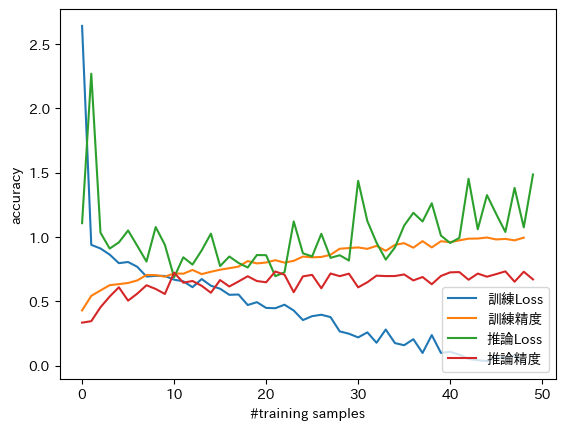

In [21]:
plt.figure()
df_train_loss_acc.plot()

plt.xlabel('#training samples')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
#plt.ylim([0, 1.01])
plt.show()

## ConfusionMatrix

In [22]:
load_weights = torch.load('model_weight.pth')
model.load_state_dict(load_weights)

<All keys matched successfully>

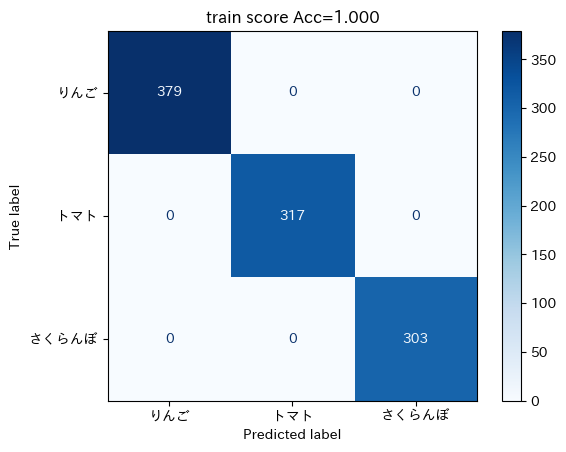

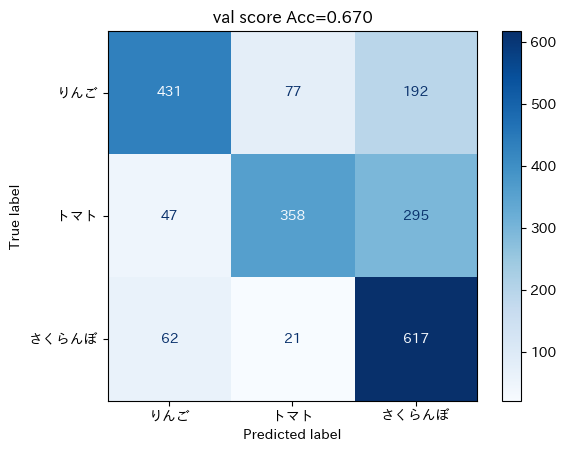

In [23]:
for phase, dataloader in dataloaders_dict.items():
  y_true = []
  y_pred = []

  for inputs, labels in dataloader:
    model.eval()
    with torch.set_grad_enabled(False):
      outputs = model.to('cpu')(inputs)
      _, preds = torch.max(outputs, 1)

    y_true.extend(labels.tolist())
    y_pred.extend(preds.tolist())

  #スコアの計算
  accuracy = accuracy_score(y_true, y_pred)

  #混合行列
  cm = confusion_matrix(y_pred = y_pred, y_true = y_true)
  cmp = ConfusionMatrixDisplay(cm, display_labels = ["りんご", "トマト", "さくらんぼ"])
  cmp.plot(cmap = plt.cm.Blues)
  cmp.ax_.set_title(f"{phase} score Acc={accuracy:.3f}")
  plt.show()

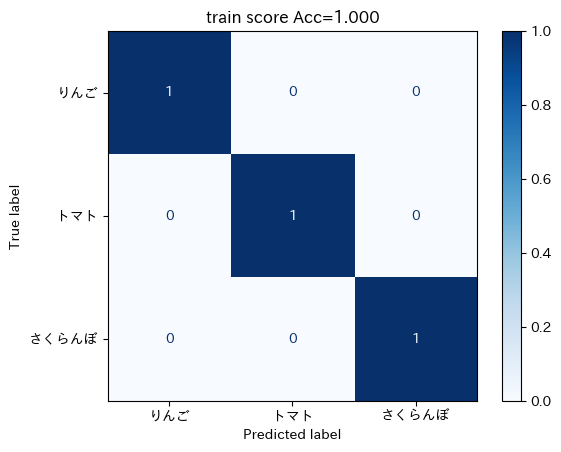

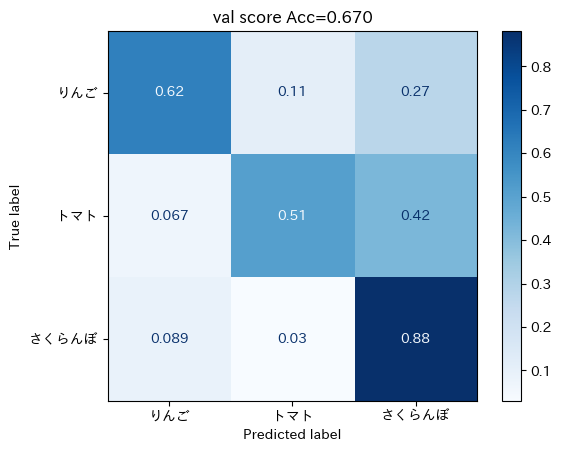

In [24]:
for phase, dataloader in dataloaders_dict.items():
  y_true = []
  y_pred = []

  for inputs, labels in dataloader:
    model.eval()
    with torch.set_grad_enabled(False):
      outputs = model.to('cpu')(inputs)
      _, preds = torch.max(outputs, 1)

    y_true.extend(labels.tolist())
    y_pred.extend(preds.tolist())

  #スコアの計算
  accuracy = accuracy_score(y_true, y_pred)

  #混合行列
  cm = confusion_matrix(y_pred = y_pred, y_true = y_true, normalize = "true")
  cmp = ConfusionMatrixDisplay(cm, display_labels = ["りんご", "トマト", "さくらんぼ"])
  cmp.plot(cmap = plt.cm.Blues)
  cmp.ax_.set_title(f"{phase} score Acc={accuracy:.3f}")
  plt.show()